In [1]:
import numpy as np
import pandas as pd
import pickle

In [1]:
!pip install gdown

In [2]:
!gdown "1-0CfuTbiTOIfDr4R76MO4Hd7GVeFlSrn"
!gdown "13UONDopwe65QnuMK6jJWQUIdyx3OI-FA"
!gdown "1-0eCfZ8xSvLAI4RuC2e1WLf_Z09GmAaN"

! gdown "1Kqf7-0Jkp1doGJWyhgxW1ku738IO4xji"
! gdown "1x_D1Feh88EFHQ63SEe55sAymUnztqzeK"
! gdown "1CcvUQxEuzPbwLOYjA1rxmyBxMF_au6wZ"


Downloading...
From: https://drive.google.com/uc?id=1-0CfuTbiTOIfDr4R76MO4Hd7GVeFlSrn
To: /content/test_embeddings_per_word.pkl
100% 464M/464M [00:04<00:00, 104MB/s] 
Downloading...
From: https://drive.google.com/uc?id=13UONDopwe65QnuMK6jJWQUIdyx3OI-FA
To: /content/train_embeddings_per_word.pkl
100% 2.16G/2.16G [00:16<00:00, 133MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0eCfZ8xSvLAI4RuC2e1WLf_Z09GmAaN
To: /content/val_embeddings_per_word.pkl
100% 464M/464M [00:02<00:00, 199MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Kqf7-0Jkp1doGJWyhgxW1ku738IO4xji
To: /content/test.pkl
100% 762k/762k [00:00<00:00, 127MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x_D1Feh88EFHQ63SEe55sAymUnztqzeK
To: /content/train.pkl
100% 3.59M/3.59M [00:00<00:00, 62.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CcvUQxEuzPbwLOYjA1rxmyBxMF_au6wZ
To: /content/val.pkl
100% 769k/769k [00:00<00:00, 103MB/s]


In [16]:
file_path = '/content/test.pkl'
with open(file_path, 'rb') as file:
    test = pickle.load(file)

file_path = '/content/train.pkl'
with open(file_path, 'rb') as file:
    train = pickle.load(file)

file_path = '/content/val.pkl'
with open(file_path, 'rb') as file:
    val = pickle.load(file)

In [17]:
with open('/content/train_embeddings_per_word.pkl', 'rb') as f:
    train_embedd = pickle.load(f)

with open('/content/test_embeddings_per_word.pkl', 'rb') as f:
    test_embedd= pickle.load(f)

with open('/content/val_embeddings_per_word.pkl', 'rb') as f:
    val_embedd= pickle.load(f)


# intiate the model

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(GRUModel, self).__init__()

        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        _, h_n = self.gru(x)
        out = self.dropout(h_n[-1, :, :])  # Using the last hidden state
        out = self.dense(out)
        out = self.softmax(out)
        return out

# Parameters
EPOCHS = 50
LEARNING_RATE = 0.0053516485623658835
INPUT_SIZE = 768
HIDDEN_SIZE = 256
OUTPUT_SIZE = 8  # Output size for softmax layer
DROPOUT_RATE = 0.011691195516528197
patience = 10
BATCH_SIZE = 64


# Create the model
model = GRUModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, DROPOUT_RATE)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-Entropy loss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Display the model architecture
print(model)


GRUModel(
  (gru): GRU(768, 256, batch_first=True)
  (dropout): Dropout(p=0.011691195516528197, inplace=False)
  (dense): Linear(in_features=256, out_features=8, bias=True)
  (softmax): Softmax(dim=1)
)


In [7]:
#preparing the labels for traning
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(train['label'], num_classes=8)
y_val_one_hot   = to_categorical(val['label'], num_classes=8)
y_test_one_hot  = to_categorical(test['label'], num_classes=8)

cpu training

In [16]:
# Convert NumPy arrays to PyTorch tensors
train_embedd_tensor = torch.tensor(train_embedd, dtype=torch.float32)
y_train_one_hot_tensor = torch.tensor(y_train_one_hot, dtype=torch.float32)

val_embedd_tensor = torch.tensor(val_embedd, dtype=torch.float32)
y_val_one_hot_tensor = torch.tensor(y_val_one_hot, dtype=torch.float32)

# Initialize the model, loss function, and optimizer
model = GRUModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, DROPOUT_RATE)
criterion = nn.CrossEntropyLoss()  # Assuming labels are integers, not one-hot encoded
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

gpu training

In [26]:
train_embedd_tensor = torch.tensor(train_embedd, dtype=torch.float32).cuda()
y_train_one_hot_tensor = torch.tensor(y_train_one_hot, dtype=torch.float32).cuda()

val_embedd_tensor = torch.tensor(val_embedd, dtype=torch.float32).cuda()
y_val_one_hot_tensor = torch.tensor(y_val_one_hot, dtype=torch.float32).cuda()

# Initialize the model, loss function, and optimizer and move them to GPU
model = GRUModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, DROPOUT_RATE).cuda()
criterion = nn.CrossEntropyLoss()  # Assuming labels are integers, not one-hot encoded
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

data loaders

In [27]:
# Create data loaders
train_dataset = torch.utils.data.TensorDataset(train_embedd_tensor, y_train_one_hot_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_embedd_tensor, y_val_one_hot_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
# Initialize early stopping
best_val_loss = float('inf')
counter = 0

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))  # Assuming labels are one-hot encoded
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == torch.argmax(labels, dim=1)).item()

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))  # Assuming labels are one-hot encoded

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == torch.argmax(labels, dim=1)).item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{EPOCHS}] - '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

print("Training completed.")

# Test the model on test data and compute accuracy
test_embedd_tensor = torch.tensor(test_embedd, dtype=torch.float32).cuda()
y_test_one_hot_tensor = torch.tensor(y_test_one_hot, dtype=torch.float32).cuda()
test_dataset = torch.utils.data.TensorDataset(test_embedd_tensor, y_test_one_hot_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.eval()
test_acc = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_acc += torch.sum(preds == torch.argmax(labels, dim=1)).item()

test_acc = test_acc / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch [1/50] - Train Loss: 1.8691, Train Acc: 0.4009, Val Loss: 1.6873, Val Acc: 0.5841
Epoch [2/50] - Train Loss: 1.6455, Train Acc: 0.6322, Val Loss: 1.6262, Val Acc: 0.6543
Epoch [3/50] - Train Loss: 1.5901, Train Acc: 0.6873, Val Loss: 1.6813, Val Acc: 0.5901
Epoch [4/50] - Train Loss: 1.5551, Train Acc: 0.7215, Val Loss: 1.5659, Val Acc: 0.7099
Epoch [5/50] - Train Loss: 1.5463, Train Acc: 0.7287, Val Loss: 1.5516, Val Acc: 0.7272
Epoch [6/50] - Train Loss: 1.5288, Train Acc: 0.7468, Val Loss: 1.5439, Val Acc: 0.7364
Epoch [7/50] - Train Loss: 1.5058, Train Acc: 0.7688, Val Loss: 1.5398, Val Acc: 0.7364
Epoch [8/50] - Train Loss: 1.4933, Train Acc: 0.7831, Val Loss: 1.5446, Val Acc: 0.7305
Epoch [9/50] - Train Loss: 1.4946, Train Acc: 0.7793, Val Loss: 1.5288, Val Acc: 0.7470
Epoch [10/50] - Train Loss: 1.4854, Train Acc: 0.7905, Val Loss: 1.5286, Val Acc: 0.7497
Epoch [11/50] - Train Loss: 1.4795, Train Acc: 0.7960, Val Loss: 1.5208, Val Acc: 0.7563
Epoch [12/50] - Train Loss: 1.

# Evluation on the model

In [29]:
label_to_class = {
    0: 'none',
    1: 'anger',
    2: 'joy',
    3: 'sadness',
    4: 'love',
    5: 'sympathy',
    6: 'surprise',
    7: 'fear'
}
classes = ['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear']

              precision    recall  f1-score   support

        none       0.68      0.86      0.76       229
       anger       0.60      0.85      0.70       200
         joy       0.65      0.64      0.65       205
     sadness       0.92      0.37      0.53       185
        love       0.81      0.75      0.78       193
    sympathy       0.90      0.83      0.86       156
    surprise       0.68      0.68      0.68       154
        fear       0.94      0.92      0.93       188

    accuracy                           0.74      1510
   macro avg       0.77      0.74      0.74      1510
weighted avg       0.77      0.74      0.74      1510



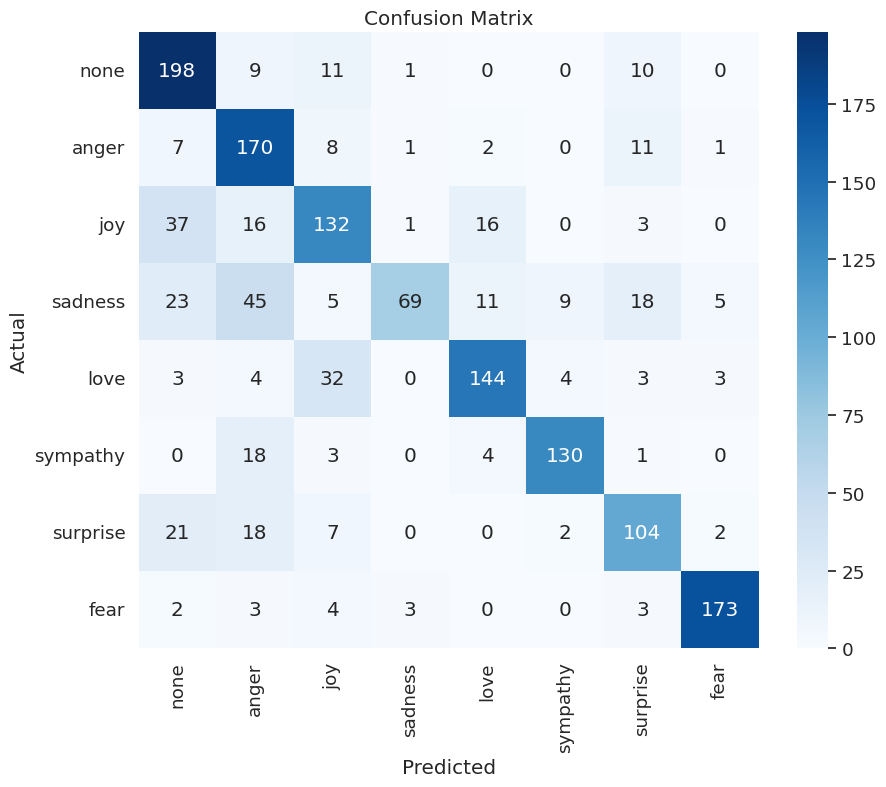

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

# Define the GRUModel class (as shown in the previous response)

# Convert NumPy arrays to PyTorch tensors and move them to GPU
test_embedd_tensor = torch.tensor(test_embedd, dtype=torch.float32).cuda()

# Create a DataLoader for test data
test_dataset = torch.utils.data.TensorDataset(test_embedd_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Make predictions
with torch.no_grad():
    for inputs in test_loader:
        outputs = model(inputs[0])  # Assuming inputs contain a single tensor
        _, preds = torch.max(outputs, 1)
        predicted_labels.extend(preds.cpu().numpy())

# Convert true labels from one-hot to class indices
true_labels = y_test_one_hot.argmax(axis=1)

# Generate classification report
target_names = classes  # Replace 'classes' with your list of class names
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap of the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
